In [1]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv src/.env

In [2]:
import os
os.chdir('/Users/kushagrasharma/coding/hormozlab/src')

from tabulate import tabulate
import numpy as np
from numpy import linalg
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import wasserstein_distance, skew, pearsonr
from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import torchvision

from tqdm import tqdm

from src.AutoEncoder import AE, Encoder, Decoder
from src.Binary2LatentNN import Binary2LatentNN
from src.Binary2TranscriptomeNN import Binary2TranscriptomeNN
from src.utils import *

import seaborn as sns
%matplotlib inline

In [3]:
DATA_DIR = os.environ.get("DATA_DIR")
MODELS_DIR = os.environ.get("MODELS_DIR")

binary_matrix_filepath = MODELS_DIR + 'binary_matrix.npy'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
### Loading Data
binary_matrix = torch.tensor(np.load(binary_matrix_filepath)).float()

train_full = pd.read_csv(DATA_DIR + 'scvi_train_set_gapdh.csv', header=None).to_numpy()
test_full = pd.read_csv(DATA_DIR + 'saver_test_set_gapdh.csv', header=None).to_numpy()

train_umap = pd.read_csv(DATA_DIR + 'train_coords.csv', header=None).to_numpy()
test_umap = np.load(DATA_DIR + 'test_saver_coords.npy')

train_tensor = torch.tensor(train_full).float()
test_tensor = torch.tensor(test_full).float()

train_binary_tensor = torch.matmul(train_tensor, binary_matrix)
test_binary_tensor = torch.matmul(test_tensor, binary_matrix)

gaussian_train = np.load(DATA_DIR + 'gaussian_train.npy')
closest_cell_to_test = np.load(DATA_DIR + 'closest_cell_to_saver_test_gapdh.npy')

gaussian_test = np.apply_along_axis(lambda x: gaussian_train[x,:], 0, closest_cell_to_test)

graph = np.load(DATA_DIR + "adjacency_15NN.npy")

N_train_cells = len(train_tensor)
N_test_cells = len(test_tensor)

### Get Laplacian
laplacian_all = np.load(DATA_DIR + 'laplacian_matrix.npy')

### Compute eigen
v_all = np.load(DATA_DIR + 'laplacian_eigenvectors.npy')

## Diving into M5

We now want to perform the same analysis for our best performing method; the neural network reconstruction of the distribution.

In [5]:
binaryToGaussian = torch.load(MODELS_DIR + 'binaryToGaussian.pt').eval()

In [6]:
toTensor = lambda x: torch.tensor(x).float()

In [7]:
input_data = test_binary_tensor
target_data = gaussian_test

In [8]:
## Error metrics
fn_on_matrix = lambda fn: lambda Y, Yhat: np.array([fn(Y[i,:], Yhat[i,:]) for i in range(len(Y))])
wassersteinOnMatrix = fn_on_matrix(wasserstein_distance)
klDivOnMatrix = fn_on_matrix(kl_div)
jsOnMatrix = fn_on_matrix(jensenshannon)

errorMetricOnMatrix = jsOnMatrix
errorMetric = lambda Y, Yh: errorMetricOnMatrix(Y, Yh).mean()

In [9]:
transform = [binaryToGaussian, lambda x: np.exp(x), normalize]

with torch.no_grad():
    results, error = transform_and_compute_error(input_data, target_data, 
                                            transform, errorMetric)
    
np.save(DATA_DIR + 'test_m5_results_saver.npy', results)

In [10]:
uniform = np.ones(N_train_cells) / (N_train_cells)
uniform_matrix = np.tile(uniform, (len(input_data), 1))

uniform_control_error = errorMetric(uniform_matrix, target_data)
error_dist = errorMetricOnMatrix(results, target_data)

Again, we first examine a scatter plot of the JS Divergence and overlay the control JS Divergence as an initial exploration.

Next, the centered and scaled JS divergence. 

Text(0, 0.5, 'Divergence Measure')

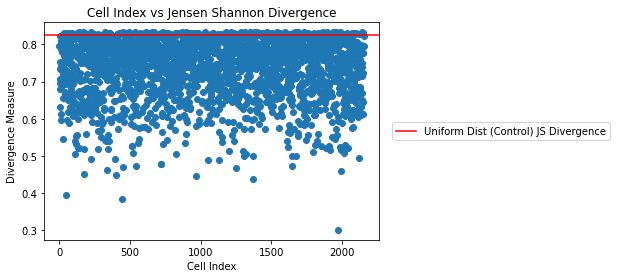

In [11]:
plt.scatter(np.arange(len(error_dist)), error_dist)
plt.axhline(y=uniform_control_error, color='r', linestyle='-', label='Uniform Dist (Control) JS Divergence')
plt.title("Cell Index vs Jensen Shannon Divergence")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.xlabel("Cell Index")
plt.ylabel("Divergence Measure")

In [12]:
error_dist.mean()

0.732119523075723

In [13]:
error_dist_centered_on_control = error_dist - uniform_control_error
error_distance_scaled = error_dist_centered_on_control / np.std(error_dist_centered_on_control)

Text(0, 0.5, 'Divergence Measure')

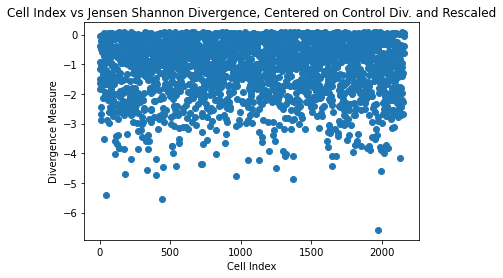

In [14]:
plt.scatter(np.arange(len(error_distance_scaled)), error_distance_scaled)
plt.title("Cell Index vs Jensen Shannon Divergence, Centered on Control Div. and Rescaled")
plt.xlabel("Cell Index")
plt.ylabel("Divergence Measure")

We plot the PDF and CDF of the centered and scaled JS divergence. 

Text(0.5, 1.0, 'Histogram (PDF) of JS Divergence, Centered and Scaled')

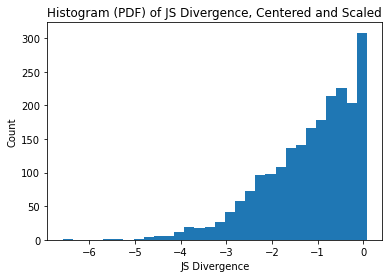

In [15]:
plt.hist(error_distance_scaled, bins=30)
plt.ylabel("Count")
plt.xlabel("JS Divergence")
plt.title("Histogram (PDF) of JS Divergence, Centered and Scaled")

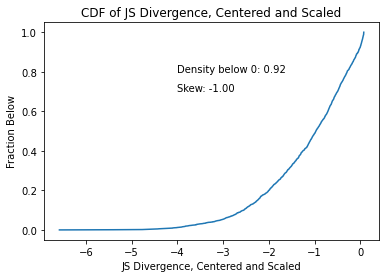

In [16]:
X2 = np.sort(error_distance_scaled)
F2 = np.array(range(len(error_distance_scaled)))/float(len(error_distance_scaled))
plt.plot(X2, F2)
plt.title("CDF of JS Divergence, Centered and Scaled")
plt.xlabel("JS Divergence, Centered and Scaled")
plt.ylabel("Fraction Below")
one_array = np.abs(X2)
one_idx = one_array.argmin()
# plt.plot((X2[one_idx], X2[one_idx]), (plt.ylim()[0], F2[one_idx]), 'r')
# plt.plot((plt.xlim()[0], X2[one_idx]), (F2[one_idx], F2[one_idx]), 'r')
ax = plt.gca()
output_coords = lambda x: ax.transLimits.inverted().transform(x)
# plt.axhline(y=F2[one_idx], xmin=0, xmax=0.49, color='r', label="Density at Control JS Div.={:.2f}".format(F2[one_idx]))
# plt.axvline(x=0, ymin=0, ymax=0.49, color='r')
plt.text(x=-4, y=0.7, s="Skew: {:.2f}".format(skew(error_distance_scaled)))
plt.text(x=-4, y=0.8, s=r"Density below 0: {:.2f}".format(F2[one_idx]))
plt.show()

As expected, this method performs very well compared to the control. It also slightly outperforms M1 on the skew.

We again plot the best and worst reconstructions side-by-side with the ground truth distributions, as well as a few random cells.

In [17]:
bten_array = np.abs(F2 - 0.1)
bten_idx = bten_array.argmin()
bten_threshold = X2[bten_idx]
bten_idxs = np.where(error_distance_scaled <= bten_threshold)[0]
bten_idxs = np.random.choice(bten_idxs, 5, replace=False)

tten_array = np.abs(F2 - 0.9)
tten_idx = tten_array.argmin()
tten_threshold = X2[tten_idx]
tten_idxs = np.where(error_distance_scaled >= tten_threshold)[0]
tten_idxs = np.random.choice(tten_idxs, 5, replace=False)

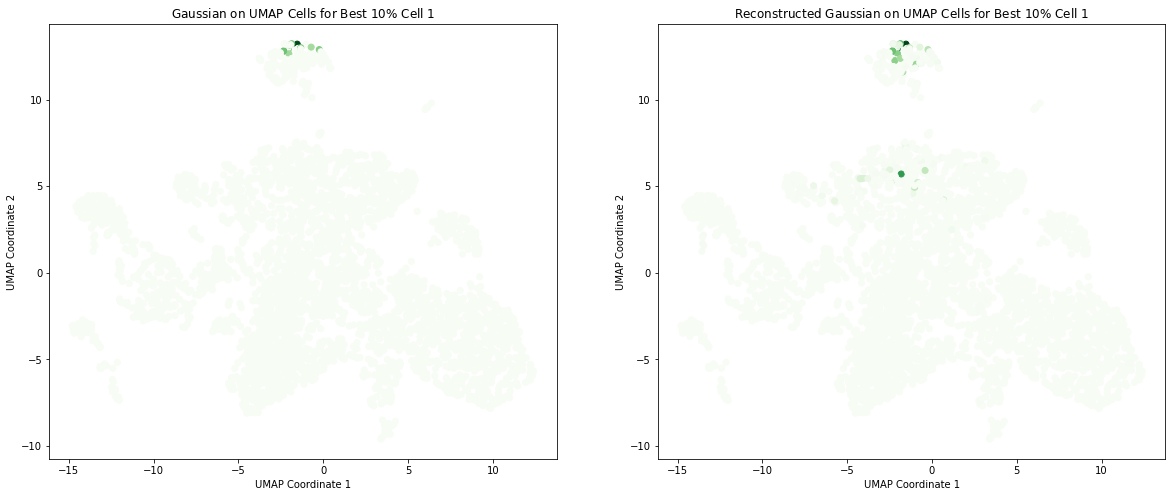

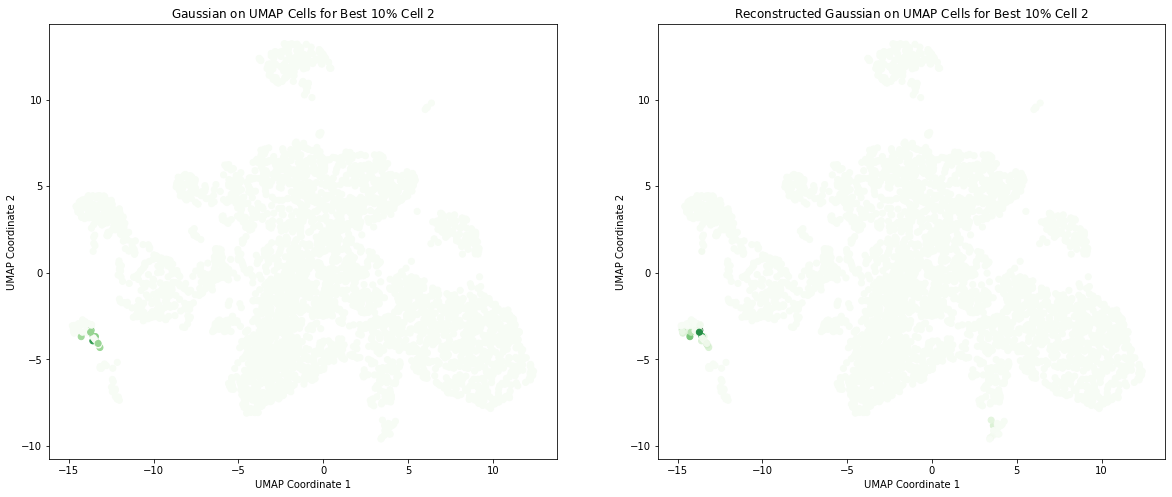

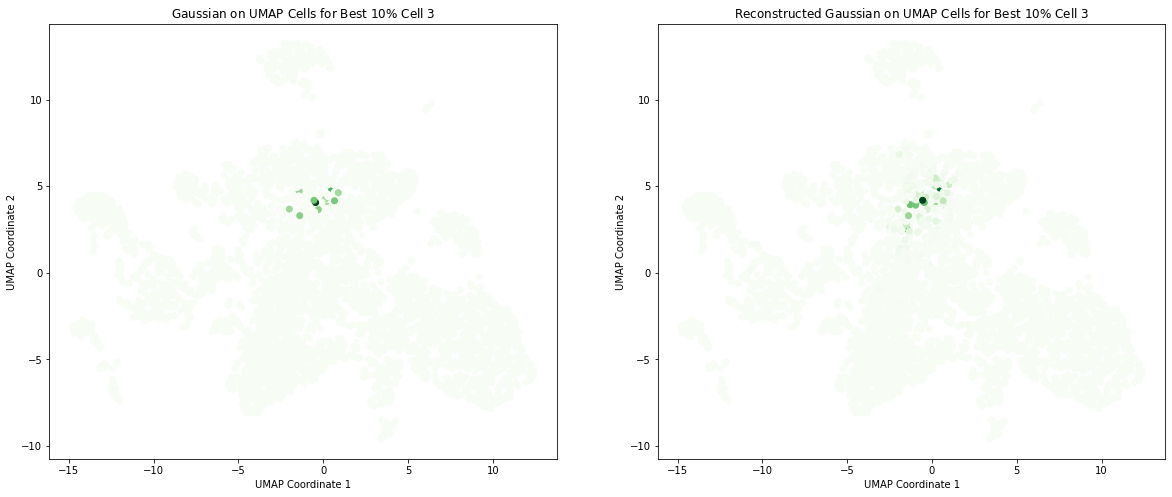

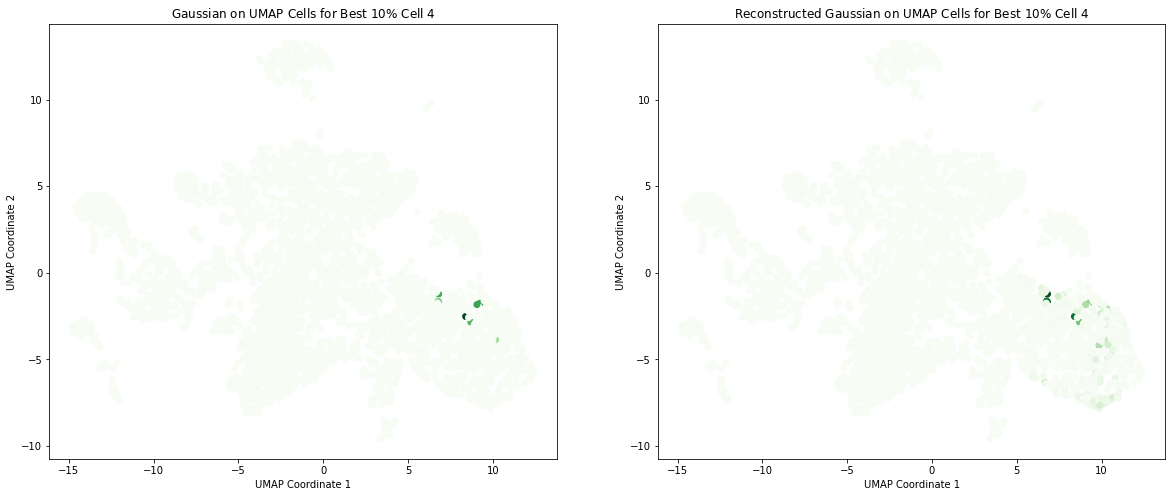

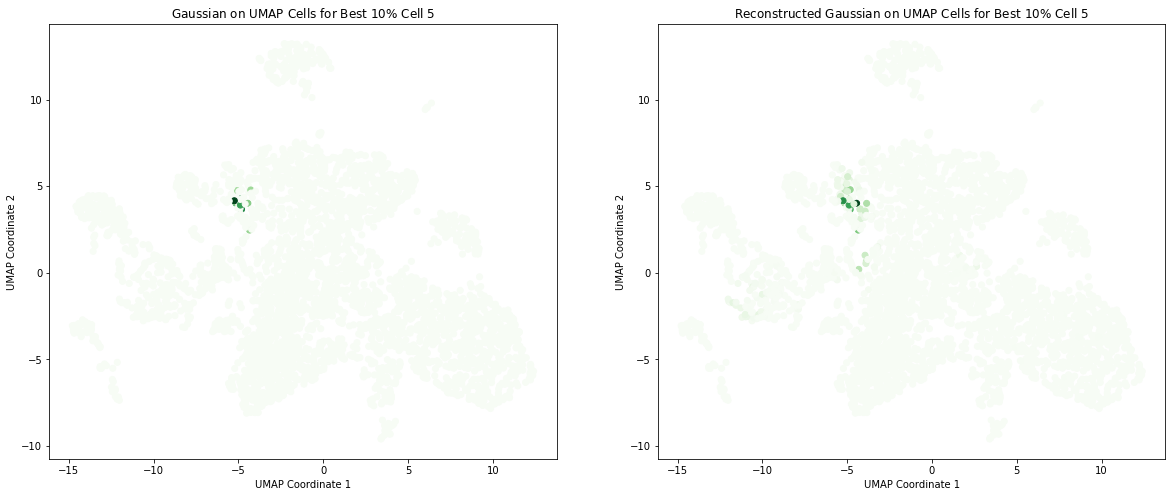

In [18]:
for i, idx in enumerate(bten_idxs):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    ax1.scatter(train_umap[:,0], train_umap[:,1], c=target_data[idx,:], cmap='Greens')
    ax1.set_title(r'Gaussian on UMAP Cells for Best $10\%$ Cell {}'.format(i+1))
    ax1.set_xlabel("UMAP Coordinate 1")
    ax1.set_ylabel("UMAP Coordinate 2")
    
    ax2.scatter(train_umap[:,0], train_umap[:,1], c=results[idx,:], cmap='Greens')
    ax2.set_title(r'Reconstructed Gaussian on UMAP Cells for Best $10\%$ Cell {}'.format(i+1))
    ax2.set_xlabel("UMAP Coordinate 1")
    ax2.set_ylabel("UMAP Coordinate 2")
    plt.show()

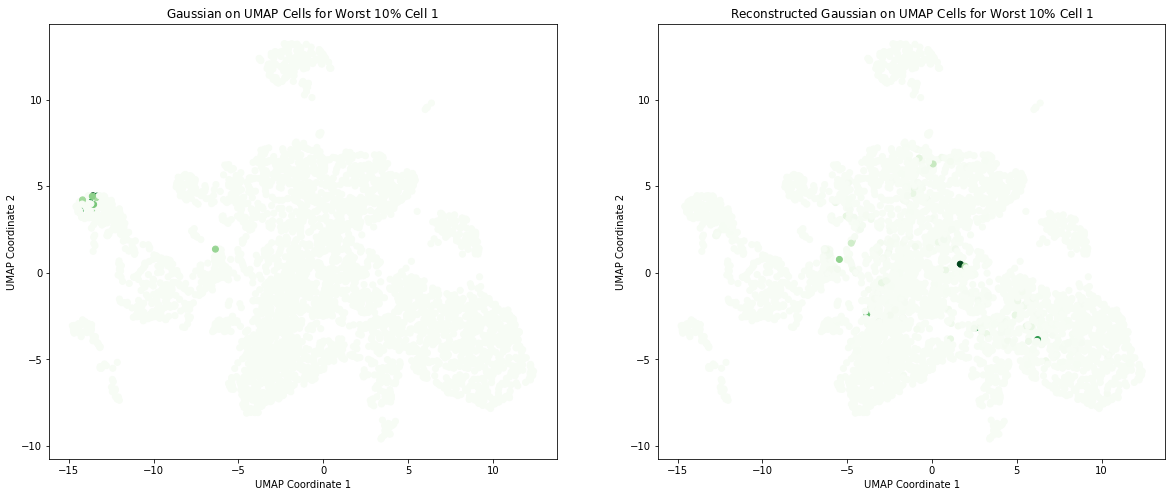

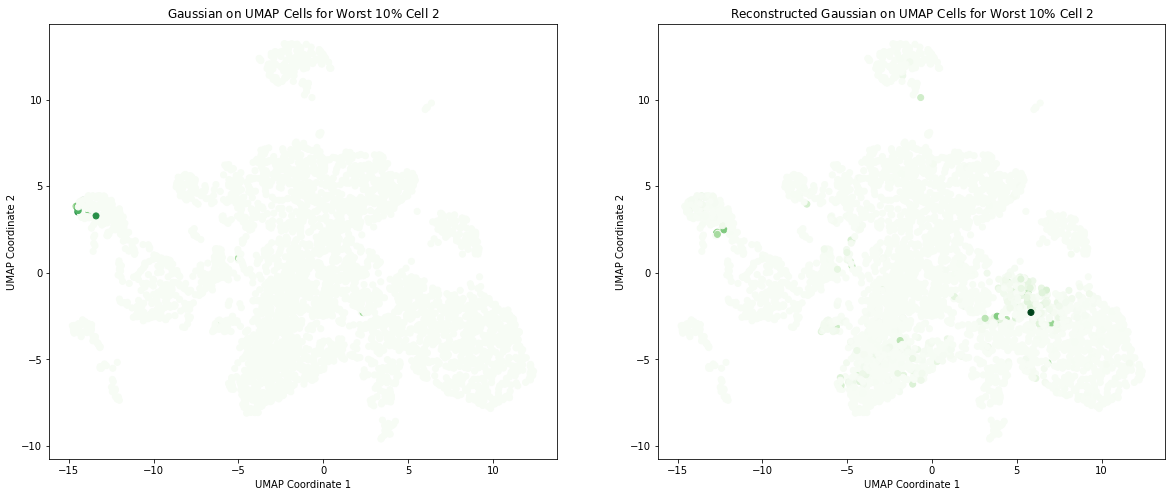

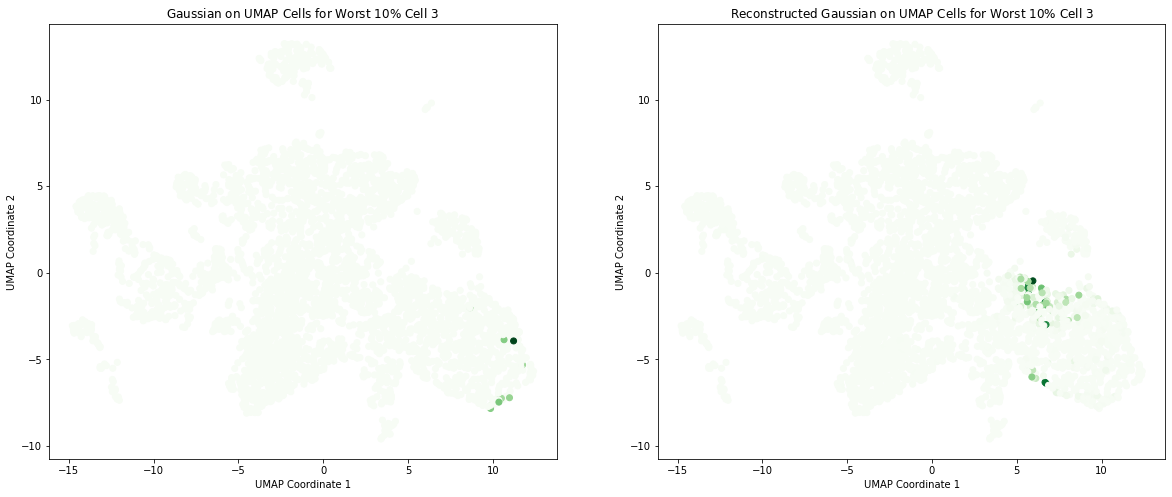

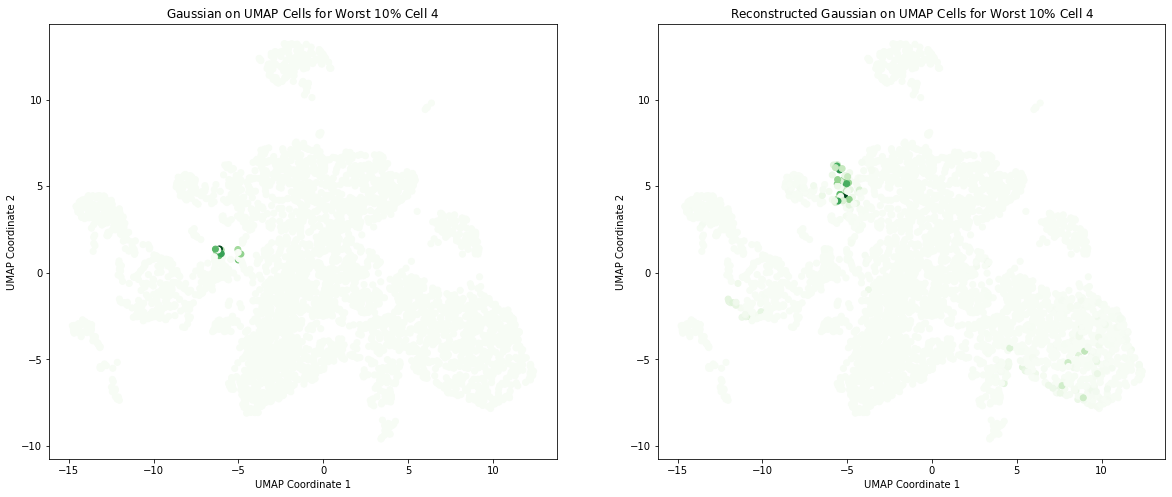

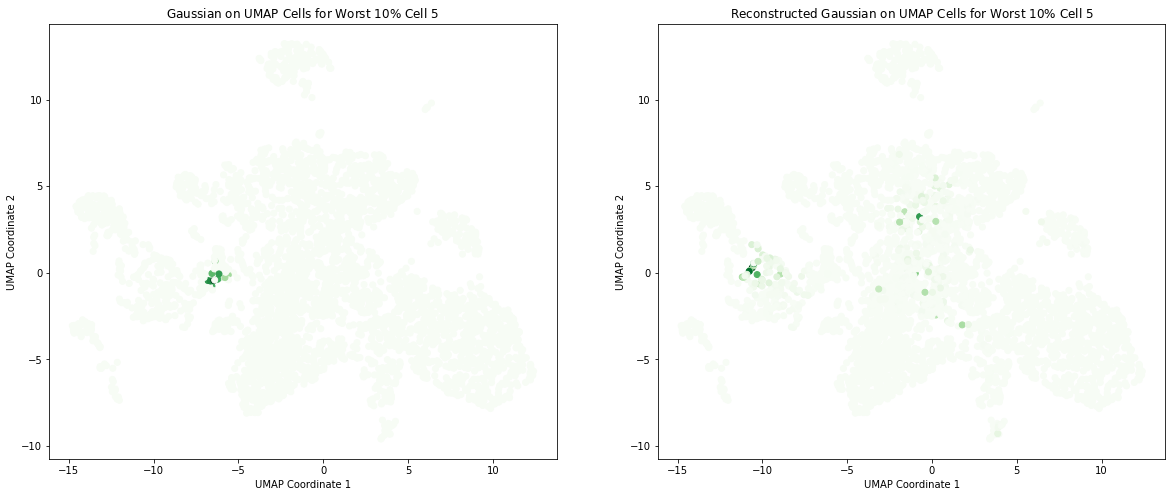

In [19]:
for i, idx in enumerate(tten_idxs):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    ax1.scatter(train_umap[:,0], train_umap[:,1], c=target_data[idx,:], cmap='Greens')
    ax1.set_title(r'Gaussian on UMAP Cells for Worst $10\%$ Cell {}'.format(i+1))
    ax1.set_xlabel("UMAP Coordinate 1")
    ax1.set_ylabel("UMAP Coordinate 2")
    
    ax2.scatter(train_umap[:,0], train_umap[:,1], c=results[idx,:], cmap='Greens')
    ax2.set_title(r'Reconstructed Gaussian on UMAP Cells for Worst $10\%$ Cell {}'.format(i+1))
    ax2.set_xlabel("UMAP Coordinate 1")
    ax2.set_ylabel("UMAP Coordinate 2")
    plt.show()

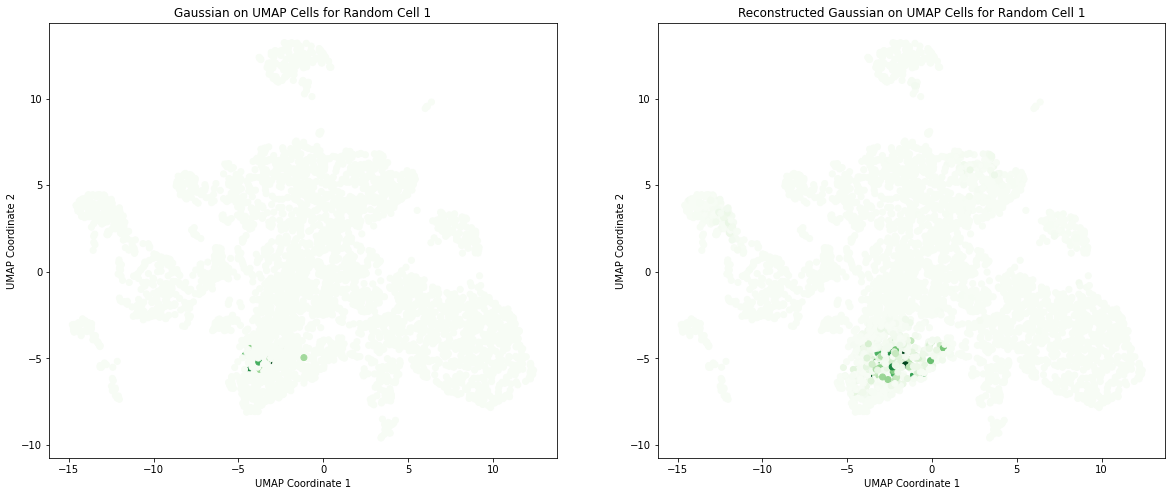

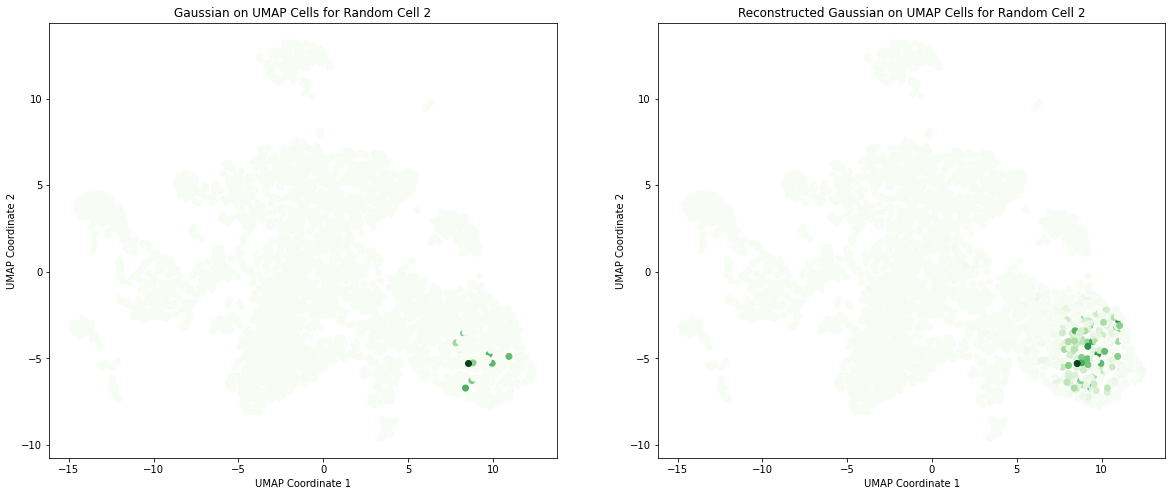

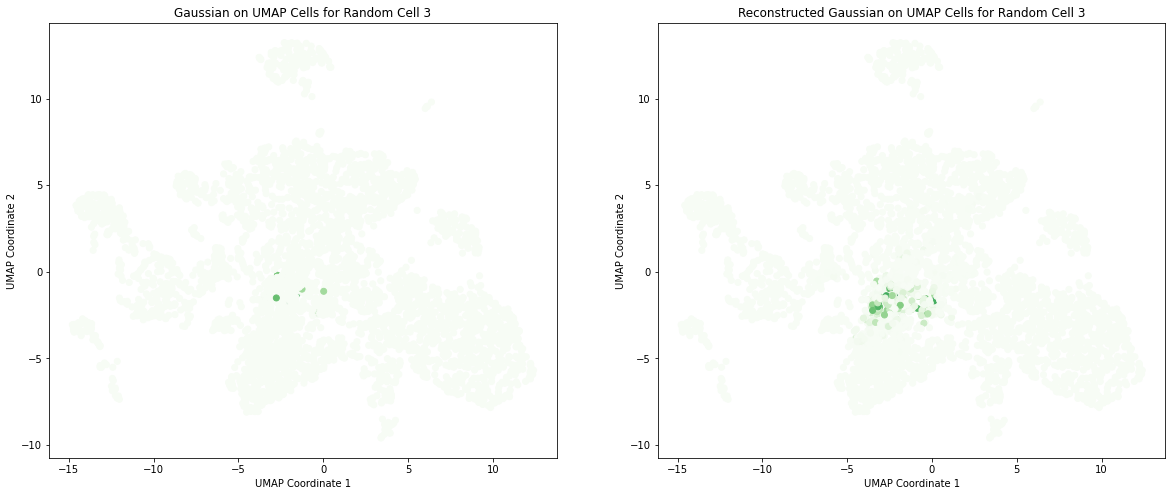

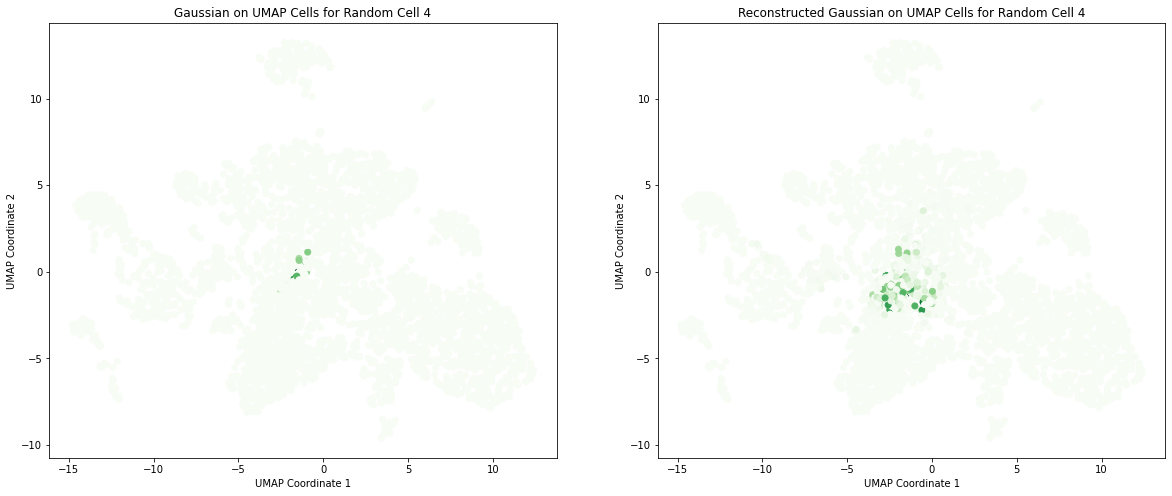

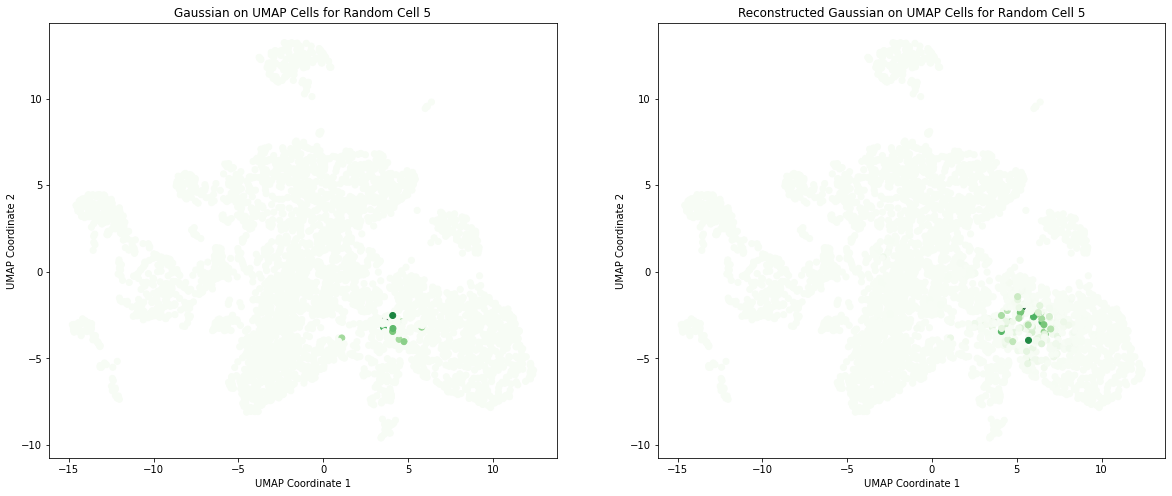

In [20]:
for i in range(5):
    idx = np.random.choice(np.arange(len(gaussian_test)))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    ax1.scatter(train_umap[:,0], train_umap[:,1], c=target_data[idx,:], cmap='Greens')
    ax1.set_title(r'Gaussian on UMAP Cells for Random Cell {}'.format(i+1))
    ax1.set_xlabel("UMAP Coordinate 1")
    ax1.set_ylabel("UMAP Coordinate 2")
    
    ax2.scatter(train_umap[:,0], train_umap[:,1], c=results[idx,:], cmap='Greens')
    ax2.set_title(r'Reconstructed Gaussian on UMAP Cells for Random Cell {}'.format(i+1))
    ax2.set_xlabel("UMAP Coordinate 1")
    ax2.set_ylabel("UMAP Coordinate 2")
    plt.show()

For our best performing reconstructions, unlike M1, we appear to have tight distributions that closely match the localization of the original distributions. Even our worst reconstructions have decent performance - some degree of the original pattern is being reconstructed. We see that our random cell reconstructions maintain the problem we saw with M1 with distributions being diffuse. 

In [21]:
gene_indexes = [4512, 8127, 2782]
gene_labels = ['CA1', 'ITGA2B', 'CRHBP']

In [22]:
test_reconstructed_tome = np.dot(results, train_full)

np.save(DATA_DIR + 'reconstructed_tome_m5_saver.npy', test_reconstructed_tome)

Again, we plot the $\log$ marker gene reconstruction expression levels against the ground truth.

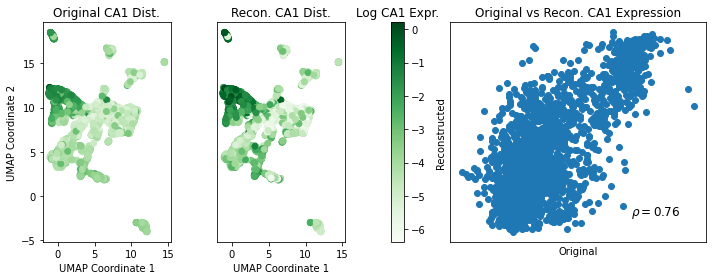

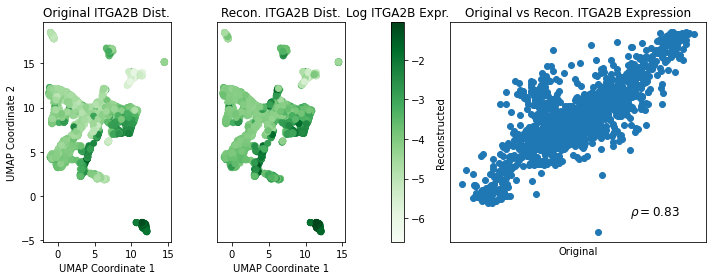

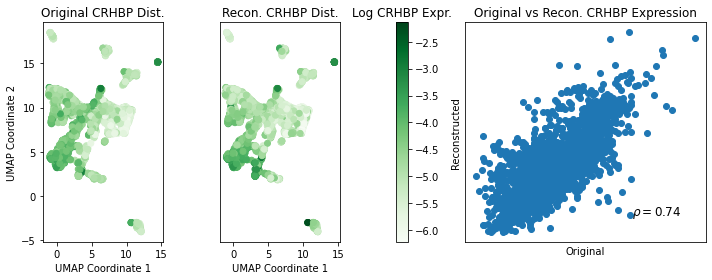

In [23]:
for i in range(len(gene_indexes)):
    original_gene_data = np.log(test_full[:, gene_indexes[i]])
    recon_gene_data = np.log(test_reconstructed_tome[:, gene_indexes[i]])
    corr, _ = pearsonr(original_gene_data, recon_gene_data)
    gene_label = gene_labels[i]

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(10,4), gridspec_kw={'width_ratios': [1, 1, 0.1, 2]})
    ax1.scatter(test_umap[:,0], test_umap[:,1], c=original_gene_data, cmap='Greens')
    ax1.set_title('Original {} Dist.'.format(gene_label))
    ax1.set_xlabel('UMAP Coordinate 1')
    ax1.set_ylabel('UMAP Coordinate 2')

    im = ax2.scatter(test_umap[:,0], test_umap[:,1], c=recon_gene_data, cmap='Greens')
    ax2.set_title('Recon. {} Dist.'.format(gene_label))
    ax2.set_xlabel('UMAP Coordinate 1')
    ax2.set_yticks([])
    
    fig.colorbar(im, cax=ax3)
    ax3.set_title("Log {} Expr.".format(gene_label))
    
    
    ax4.scatter(original_gene_data, recon_gene_data)
    ax4.set_xlabel('Original')
    ax4.set_ylabel('Reconstructed')
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_title("Original vs Recon. {} Expression".format(gene_label))
    ax4.text(0.9, 0.1, r'$\rho={:.2f}$'.format(corr), fontsize=12,horizontalalignment='right',
             verticalalignment='bottom', transform = ax4.transAxes)

    
    fig.tight_layout()

    plt.show()

In [24]:
joint_umap = np.load(DATA_DIR + 'umap_m5_saver.npy')

joint_test_umap = joint_umap[:len(test_full),:]
joint_results_umap = joint_umap[len(test_full):,:]

Finally, we compute the joint UMAP of the ground truth transcriptomes with the reconstructed transcriptomes, and then draw lines connecting each ground truth coordinate with the corresponding reconstructed coordinate.

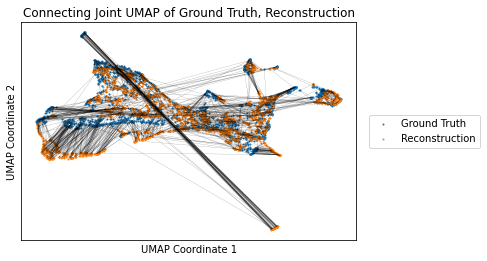

In [25]:
plt.scatter(joint_test_umap[:,0], joint_test_umap[:,1], s=1, label='Ground Truth')
plt.scatter(joint_results_umap[:,0], joint_results_umap[:,1], s=1, label='Reconstruction')
plt.yticks([])
plt.xticks([])
plt.xlabel("UMAP Coordinate 1")
plt.ylabel("UMAP Coordinate 2")
plt.title("Connecting Joint UMAP of Ground Truth (SAVER), Reconstruction")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

for i in range(len(joint_test_umap)):
    plt.plot((joint_test_umap[i,0], joint_results_umap[i,0]), 
             (joint_test_umap[i,1], joint_results_umap[i,1]), 'black', linewidth=0.1)

Our final exmainations show that M5 performs similarly to M1, but slightly better on some evaluation metrics. 

In [27]:
joint_umap_scvi = np.load(DATA_DIR + 'umap_m5_saver_scvi.npy')

joint_test_umap_scvi = joint_umap_scvi[:len(test_full),:]
joint_results_umap_scvi = joint_umap_scvi[len(test_full):,:]

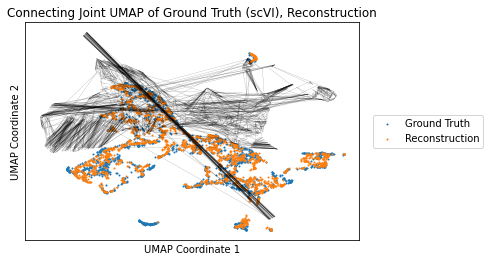

In [28]:
plt.scatter(joint_test_umap_scvi[:,0], joint_test_umap_scvi[:,1], s=1, label='Ground Truth')
plt.scatter(joint_results_umap_scvi[:,0], joint_results_umap_scvi[:,1], s=1, label='Reconstruction')
plt.yticks([])
plt.xticks([])
plt.xlabel("UMAP Coordinate 1")
plt.ylabel("UMAP Coordinate 2")
plt.title("Connecting Joint UMAP of Ground Truth (scVI), Reconstruction")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

for i in range(len(joint_test_umap)):
    plt.plot((joint_test_umap[i,0], joint_results_umap[i,0]), 
             (joint_test_umap[i,1], joint_results_umap[i,1]), 'black', linewidth=0.1)